## 目次

配信URL: https://youtube.com/live/61lrElGgDSs?feature=share

* データを知る
* 特徴量を作る
* モデルを作る
* 結果を解釈する
* 予測をして submission file を作る

In [1]:
import os
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from contextlib import contextmanager
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


In [2]:
# 各自の環境に合わせてパスを書き換えてください
# INPUT_DIR: 配布されたデータが格納されているディレクトリ
# OUTPUT_DIR: この notebook で作ったファイルを格納するディレクトリ
INPUT_DIR = "/analysis/data/raw/"
OUTPUT_DIR = "/analysis/data/outputs/tutorial-1"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# INPUT_DIR には atmacup15 で配布されたデータが入っています.
glob(os.path.join(INPUT_DIR, "*"))

['/analysis/data/raw/test.csv',
 '/analysis/data/raw/anime.csv',
 '/analysis/data/raw/sample_submission.csv',
 '/analysis/data/raw/train.csv']

In [4]:
def read_csv(name: str, **kwrgs) -> pd.DataFrame:
    p = os.path.join(INPUT_DIR, name + ".csv")
    return pd.read_csv(p, **kwrgs)

In [5]:
anime_df = read_csv("anime")

train_df = read_csv("train")
test_df = read_csv("test")

In [6]:
train_df.head()

,user_id,anime_id,score
0,0008e10fb39e55447333,0669cc0219d468761195,2
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1
3,0008e10fb39e55447333,2290175205d55e81b197,8
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9


## データを知る

まず、コードとかをかかずにわれわれは今どういうデータを取り扱っていて何を予測することが求められているのかについての理解を深めておきましょう。

### 1: スキーマ(構造)を確認する

一番初めにやることは、コードを書くことではなくデータのスキーマと実際にどういうデータが入っているのかを確認することです。

自分が使える情報は何か・それはどのような構造を持っているか・実際にどういう値が入っているかをしっかりと把握してください。今回のデータは train / test 以外にも使えるテーブルがいくつか存在しています。データタブに各テーブルが持っている Field の情報が書かれていますので、ちゃんと読んでおきましょう。

### 2: 実際にデータを眺める

全体の構造がざっと理解できたら、次は実際にデータをみましょう。この実際に見るというのは pandas で head を print とかではなくて、エクセルで開いて、フィルタなどを活用しながらデータを確認するようなちょっと泥臭い作業を指します。

この作業を経ることで、データに対する肌感を感じられます。例えば今回使えるデータはどれも容量が小さいですからローカルでエクセルで開いてみて、ぱっぱっぱーっと見ていくだけでもだいぶ違うでしょう。このとき思ったこと・感じたことは, テーブルごとなどでどこかにメモしておくとあとあとで処理をするときに役に立って感動することがあります。

### 3: 集計値を見る

In [7]:
# ydata-profiling というライブラリを使います
# 昔は pandas-profiling という名前でした.

# もし install する場合は以下をコメントアウトしてください。
# !pip install -U ydata-profiling

In [8]:
from ydata_profiling import ProfileReport

In [9]:
report = ProfileReport(anime_df)

In [10]:
report.to_file(os.path.join(OUTPUT_DIR, "anime_report.html"))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
train_repot = ProfileReport(train_df)
test_report = ProfileReport(test_df)

In [12]:
compare_report = train_repot.compare(test_report)
compare_report.to_file(os.path.join(OUTPUT_DIR, "compare_train_vs_test.html"))

/home/penguin/.conda/lib/python3.7/site-packages/ydata_profiling/compare_reports.py:196: UserWarning: The datasets being profiled have a different set of columns. Only the left side profile will be calculated.
  "The datasets being profiled have a different set of columns. "


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 機械学習モデルの作成

### 機械学習モデルとは

機械学習モデルとは、ざっと行ってしまうとあるデータ X を入力として対応する予測値 y を取り出すような関数です。

例えば有名なタイタニック問題では、乗客が生きるか死ぬかを予測する問題ですが、X に対応するのは乗客の年齢, 性別, 船室のグレード… といった乗客の情報で y はその乗客が生き残ったかどうかの 0-1 の値、が対応します。この入力Xの情報を特徴量といいます。

機械学習では、X を入れると y になるような関数を作ることが目的ですが、この関数の中身のロジックを人が作らないところが大きな特徴です。例えば「性別が男だから助かる確率は 0.2 減る」といったことを人が設計しません。

反対に、特徴量 X と予測したい値 y の関係がわかっているデータをアルゴリズムに与えてどういう X なら y=1 (あるいは y=0) になりやすいか? のパターンをみつける、という上記と真逆のアプローチを取ります。この調整のフェーズを学習とよびます。学習には様々なアルゴリズムがありますが、X, y を用意しなくてはならない部分は基本的に変わりません。

### 特徴量エンジニアリング

特徴量は予測対象に対して紐づくような値 (属性) です。

機械学習モデルは基本的に数値しか扱えませんから、何らかの方法で表現したい情報を数値化する必要があります。先のタイタニックで言うと、性別は文字列なので何らかの方法で性別を表すような数字の表現に直す工程が必要です。また、機械学習では画像などを取り扱う場合もありますが、画像であればピクセルの RGB (W x H x 3 の matrix 化) を、自然言語であれば分かち書き等の手法によって、最終的に数値化されて機械学習へとインプットされています。数値への変換は人間の仕事です。

この表現を作っていく工程のことを特徴量エンジニアリング (feature engineering) とよびます。特徴量は機械学習が考慮可能な情報を定めているため、ここに y を予想する上で重要な情報を以下に組み込むか? がとても大事です。機械学習アルゴリズムによる差分もありますが、同じアルゴリズムを使っていても特徴量が違うと大きな性能の差が生まれることはよくあります。

## 今回の問題の特徴量と予測値

今回のタスクは

> アニメ作品の情報とユーザーからの評価のデータを元にして、評価のわかっていないユーザー・作品の組に対する評価を予測してください。

というものでした。すなわち `train.csv` にあるようにアニメID/ユーザーID という入力 X から、評価 y を求める機械学習モデルを作ることが必要です。

特徴量はアニメIDあるいはユーザーIDに紐づくものを用意する必要があることもわかるでしょう。

## anime_id 由来の特徴量

まずはじめに `anime_id` から紐付けることができる特徴量を考えてみましょう。今回のデータにはアニメの特徴が記載されている `anime.csv` があります。この情報を特徴量として見ましょう。

In [13]:
anime_df.head()

,anime_id,genres,japanese_name,type,episodes,aired,producers,licensors,studios,source,duration,rating,members,watching,completed,on_hold,dropped,plan_to_watch
0,000ba7f7e34e107e7544,"Comedy, Sci-Fi, Seinen, Slice of Life, Space",宇宙兄弟,TV,99,"Apr 1, 2012 to Mar 22, 2014","Aniplex, Dentsu, YTV, Trinity Sound",Sentai Filmworks,A-1 Pictures,Manga,24 min. per ep.,PG-13 - Teens 13 or older,150428,16552,37234,13009,6948,76685
1,00427279d72064e7fb69,"Adventure, Slice of Life, Mystery, Historical,...",蟲師,TV,26,"Oct 23, 2005 to Jun 19, 2006","Avex Entertainment, Marvelous, SKY Perfect Wel...",Funimation,Artland,Manga,25 min. per ep.,PG-13 - Teens 13 or older,620736,55482,235371,42786,20017,267080
2,00444b67aaabdf740a68,"Adventure, Slice of Life, Mystery, Historical,...",蟲師 続章,TV,10,"Apr 5, 2014 to Jun 21, 2014","Aniplex, Kodansha, Delfi Sound",Aniplex of America,Artland,Manga,24 min. per ep.,PG-13 - Teens 13 or older,226522,12585,113559,6095,2606,91677
3,00839a3507ab168abe75,"Comedy, Ecchi, Fantasy, School",星刻の竜騎士,TV,12,"Apr 5, 2014 to Jun 21, 2014","Media Factory, AT-X, Sony Music Communications...",Funimation,C-Station,Light novel,24 min. per ep.,R+ - Mild Nudity,170220,8723,118202,3753,8034,31508
4,0192331235e110fe4f76,"Comedy, Harem, Romance, Sci-Fi, Shounen, Space",天地無用！,TV,26,"Apr 2, 1995 to Sep 24, 1995","TV Tokyo, Pioneer LDC","Funimation, Geneon Entertainment USA",AIC,Original,23 min. per ep.,PG-13 - Teens 13 or older,62599,2565,39890,2093,1986,16065


### 数値な特徴量

Profiling Report によると members は数字の列なので、特徴量としてそのまま使えそうです。

In [14]:
anime_df["members"]

0       150428
1       620736
2       226522
3       170220
4        62599
         ...  
1995     65360
1996     93558
1997    426616
1998    178908
1999     66799
Name: members, Length: 2000, dtype: int64

In [15]:
def merge_by_anime_id(left_df, right_df):
    return pd.merge(left_df["anime_id"], right_df, on="anime_id", how="left").drop(columns=["anime_id"])

In [16]:
def create_anime_numeric_feature(input_df: pd.DataFrame):
    """input_dfは train or test.csv のデータが入ってくることを想定しています."""
    
    use_columns = [
        "members", 
    ]
    
    return merge_by_anime_id(input_df, anime_df)[use_columns]

In [17]:
create_anime_numeric_feature(train_df)

,members
0,542642
1,650309
2,137560
3,1255830
4,97346
...,...
136396,271047
136397,591140
136398,159116
136399,1133952


### カテゴリな特徴量

カテゴリ変数の列もあります。例えば `"type"` などですね! これは文字列のためそのままでは特徴量として使うことができません。

In [18]:
anime_df["type"]

0       TV
1       TV
2       TV
3       TV
4       TV
        ..
1995    TV
1996    TV
1997    TV
1998    TV
1999    TV
Name: type, Length: 2000, dtype: object

<AxesSubplot:>

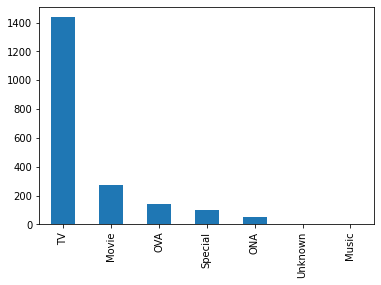

In [19]:
anime_df["type"].value_counts().plot(kind="bar")

type は出てくる文字列の種類が決まっていて、自由入力のような形式ではないことがわかります。このような変数はカテゴリ変数と呼ばれます。

カテゴリ変数を特徴量にする方法はいくつもありますが、ここでは CountEncoding と OneHotEncoding を紹介します。

### CountEncoding

見ての通りではありますが、カテゴリの値をその出現回数 (Count) で置き換える方法です。

In [20]:
# 実装のスケッチ.
# TV → 1436 に変換されていることがわかる
anime_df["type"].map(anime_df["type"].value_counts())

0       1436
1       1436
2       1436
3       1436
4       1436
        ... 
1995    1436
1996    1436
1997    1436
1998    1436
1999    1436
Name: type, Length: 2000, dtype: int64

In [21]:
# 関数にしておきましょう!

def create_anime_type_count_encoding(input_df):
    count = anime_df["type"].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        "tyoe_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

In [22]:
create_anime_type_count_encoding(train_df)

,tyoe_count
0,1436
1,50
2,142
3,1436
4,97
...,...
136396,1436
136397,1436
136398,1436
136399,1436


### OneHotEncoding

カテゴリがある値のとき 1 そうでないとき 0 というような 0-1 のフラグに置き換える方法です。CountEncoding よりも元の列の情報を残すことができますが、一方でカテゴリのユニークな値の数 N だけ列が必要になるため、

1. カテゴリのユニーク数が多いときには、列が膨大になりメモリに乗らなくなる可能性があることと
2. 情報が多数の列に分散して疎な状態 (スパース) になり、機械学習モデルがうまく列の情報を使えなくなる可能性があること

の2点に注意が必要です。

In [23]:
# 実装のスケッチ

# 対象の列のユニーク集合を取る
target_colname = "type"
target_series = anime_df[target_colname]
unique_values = target_series.unique()

# ユニークな値ごとに列を作る
out_df = pd.DataFrame()
for value in unique_values:
    is_value = target_series == value
    out_df[value] = is_value.astype(int)

In [24]:
# こんなふうな 0-1 の Matrix になる
out_df

,TV,Special,Movie,Unknown,ONA,OVA,Music
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1995,1,0,0,0,0,0,0
1996,1,0,0,0,0,0,0
1997,1,0,0,0,0,0,0
1998,1,0,0,0,0,0,0


<AxesSubplot:>

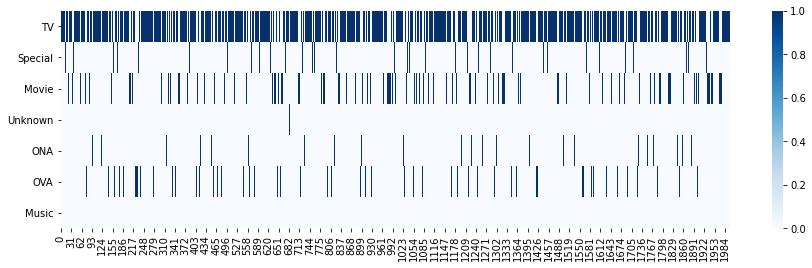

In [25]:
# heatmap で可視化. 青色が濃い部分が 1 なのでその行が特定の値であることを示す (ぱっと見るだけで TV が多そうですね)
fig, ax = plt.subplots(figsize=(15, 4))
sns.heatmap(out_df.T, ax=ax, cmap="Blues", )

In [26]:
# 関数にしておきましょう!

def create_anime_type_one_hot_encoding(input_df):
    
    # 対象の列のユニーク集合を取る
    target_colname = "type"
    target_series = anime_df[target_colname]
    unique_values = target_series.unique()

    # ユニークな値ごとに列を作る
    out_df = pd.DataFrame()
    for value in unique_values:
        is_value = target_series == value
        out_df[value] = is_value.astype(int)
        
    out_df["anime_id"] = anime_df["anime_id"]
    
    return merge_by_anime_id(input_df, out_df)

In [27]:
# 確認!
create_anime_type_one_hot_encoding(train_df)

,TV,Special,Movie,Unknown,ONA,OVA,Music
0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
136396,1,0,0,0,0,0,0
136397,1,0,0,0,0,0,0
136398,1,0,0,0,0,0,0
136399,1,0,0,0,0,0,0


### Q: ユーザーID由来の特徴量はどのようなものが考えられるでしょうか?

> hint: 例えば「全部で何作品みている?」などは特徴量として使えそうですね。

## 特徴量のマージ

上記の特徴量作成関数を連続的に呼び出し & 結合して、学習に使う特徴量全体にしましょう。

In [28]:
def create_feature(input_df):
    
    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_anime_numeric_feature,
        create_anime_type_count_encoding,
        create_anime_type_one_hot_encoding,
    ]
    
    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        with Timer(prefix=f"create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [29]:
# 実行して train / test 用の特徴量を作ります.

with Timer(prefix="train..."):
    train_feat_df = create_feature(train_df)

with Timer(prefix="test..."):
    test_feat_df = create_feature(test_df)

X = train_feat_df.values
y = train_df["score"].values

create create_anime_numeric_feature 0.054[s]
create create_anime_type_count_encoding 0.013[s]
create create_anime_type_one_hot_encoding 0.017[s]
train... 0.088[s]
create create_anime_numeric_feature 0.045[s]
create create_anime_type_count_encoding 0.011[s]
create create_anime_type_one_hot_encoding 0.016[s]
test... 0.074[s]


## 学習を行なう

特徴量を作成できたので次にモデルの学習を行っていきます。この時大事になるのが交差検証 (Cross Validation) という考え方です。

### Cross Validation とは

Cross Validation とは学習用のデータセットを複数に分割してそれぞれの分割で学習・検証のデータセットを作り、モデルの性能を見積もる枠組みのことです。

### なんで Cross Validation するの?

なぜわざわざ分割するの? (そのまま全部学習で使っちゃえばいいじゃない?) と思われるのが普通だと思います。なぜ分割するかというと学習データの中で今の枠組みの性能(枠組みと言っているのは特徴量・モデルの構成もろもろ全部が含まれるためです)を評価したいからです。手元で評価ができないとLBに出してみて一喜一憂するしかなくなり、結果publicLBにオーバーフィットしてしまうのでよろしくないです。

仕事的な観点で言ってもLBに出すというのはデプロイ(本番へ反映すること)ですから、本番に出さないとモデルの良し悪しがわからないのはよろしくないですよね?

一番ナイーブな戦略は Random と呼ばれるものです。これは何も考えずにとにかくランダムに学習データを分割します。

その他にターゲットの分布が同じになるように分割する Stratified と呼ばれる方法もあります。

あとは「各分割で特定のグループが重ならないようにする」Group もよく使われます。

その他にも時系列で区切る TimeSeriesSplit という方法もあります。

### note: どの分割方法がいいの?

いろいろと分割方法があると説明しましたが、どの分割方法が一番良いでしょうか。

まず良い分割とはなにかを考えてみましょう。良い分割とは今のモデルがテストデータでどのぐらいの性能を出すかを、検証データで確認できる分割です。

これはすなわち、分割された学習/検証用データが、全体の学習/テストデータとの対応関係と一致していることといえるでしょう。
したがって分割を決める際には学習データとテストデータの関係性をしらべ、それと同じ分割を採用する必要があります。

---

今回は目的変数の割合を保つように分割する StratifiedKFold を利用します。



In [30]:
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=510)
cv = fold.split(X, y)
cv = list(cv) # split の返り値は generator なので list 化して何度も iterate できるようにしておく

In [31]:
from sklearn.metrics import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    """mean_squared_error の root (0.5乗)"""
    return mean_squared_error(y_true, y_pred) ** .5

## LightGBM による CrossValidation を用いた学習

今回は使う機械学習モデルとして lightGBM を使います。lightGBM は以下のような良い性質があります。

* GBDT と呼ばれるアルゴリズムの一種でテーブルデータで性能が高いことが知られている
* 欠損値が存在している場合にも自然に取り扱えるため特に処理が必要ない
* 特徴量のスケールを揃えたりしなくてよい
* 特徴重要度をさっと出すことができる
+ CPU 環境でも高速に学習・推論が行える

ほかにも理由はありますが [u++ さんの 「初手LightGBM」をする7つの理由](https://upura.hatenablog.com/entry/2019/10/29/184617) などが参考になります。

In [32]:
import lightgbm as lgbm

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix="fit fold={} ".format(i)):
            
            # cv 内で train に定義された x_train で学習する
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        # cv 内で validation data とされた x_valid で予測をして oof_pred に保存していく
        # oof_pred は全部学習に使わなかったデータの予測結果になる → モデルの予測性能を見る指標として利用できる
        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = root_mean_squared_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = root_mean_squared_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return oof_pred, models

In [33]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    "objective": "rmse", 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    "n_estimators": 10000, 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    "learning_rate": .1,

    # 特徴重要度計算のロジック(後述)
    "importance_type": "gain", 
    "random_state": 510,
}

oof, models = fit_lgbm(X, y=y, params=params, cv=cv)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.50234
[100]	valid_0's rmse: 1.49681
[150]	valid_0's rmse: 1.4944
[200]	valid_0's rmse: 1.49332
[250]	valid_0's rmse: 1.49289
[300]	valid_0's rmse: 1.49263
[350]	valid_0's rmse: 1.49251
[400]	valid_0's rmse: 1.49245
[450]	valid_0's rmse: 1.49242
[500]	valid_0's rmse: 1.49239
[550]	valid_0's rmse: 1.49242
[600]	valid_0's rmse: 1.49243
Early stopping, best iteration is:
[503]	valid_0's rmse: 1.49239
fit fold=0  1.572[s]
 - fold1 - 1.4924
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.49752
[100]	valid_0's rmse: 1.49207
[150]	valid_0's rmse: 1.49018
[200]	valid_0's rmse: 1.48937
[250]	valid_0's rmse: 1.489
[300]	valid_0's rmse: 1.48878
[350]	valid_0's rmse: 1.4887
[400]	valid_0's rmse: 1.48871
[450]	valid_0's rmse: 1.48869
Early stopping, best iteration is:
[353]	valid_0's rmse: 1.48869
fit fold=1  1.051[s]
 - fold2 - 1.4887
Training until validation scores don't impro

## 結果を解釈する

モデルができた! 次は予測だ! の前に… 一度予測結果の見積もりを行いましょう。

まずは全体の予測性能です。上記でも console.log で出力されていますがこれが今回の学習の枠組み (特徴量 + 学習モデル + ...) の場合の見積もり性能になります。

In [34]:
root_mean_squared_error(y_true=y, y_pred=oof)

1.4916386856838029

### Q: 正解ラベルごとの予測値の分布はどうなっているだろうか?

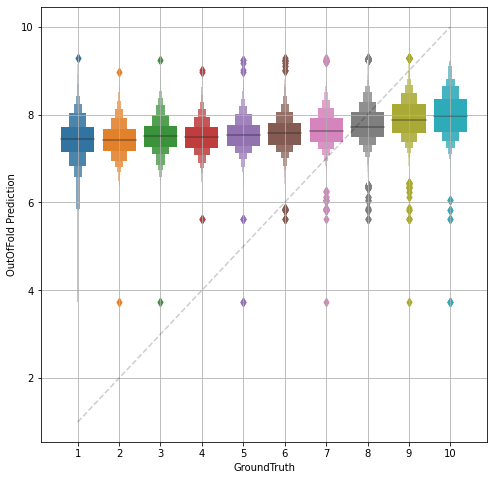

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.boxenplot(data=pd.DataFrame({ "GroundTruth": y, "OutOfFold Prediction": oof }), 
              x="GroundTruth", y="OutOfFold Prediction", ax=ax)

ax.grid()
ax.plot([0, 9], [1, 10], "--", c="black", alpha=.2)

* 予測値 (OutOfFold) の平均値は正解ラベル (GroundTruth) の上昇に伴って若干上がっている。
* ただ 1,2 や 10 などの極端な値は大きくずれている. 

## 予測モデルの中身を理解する

LightGBM など木系のモデルではどの特徴量で分割を行ってどれだけ目的変数を説明しているかを特徴重要度 (feature importance) として出力することができます。これを見ることで

* どの特徴量が大事なのか
* どの特徴量はあまり大事ではないか

といった特徴量に関する情報を得ることができます。これによって、例えば重要となった特徴量を使う別の特徴を考えたり、反対に大事ではない特徴を削ったりといったインサイトを得ることが可能です。また何故この予測が出てくるかの解釈をする上でも有用です。

> note: 今回利用した lightGBM は内部的に特徴の値での IF をたくさん重ねているモデルなので、どの特徴で IF を作っているか + それによって予測性能がどのぐらい改善するかを利用して特徴量ごとの貢献度 (特徴重要度) を算出することができます。

In [36]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

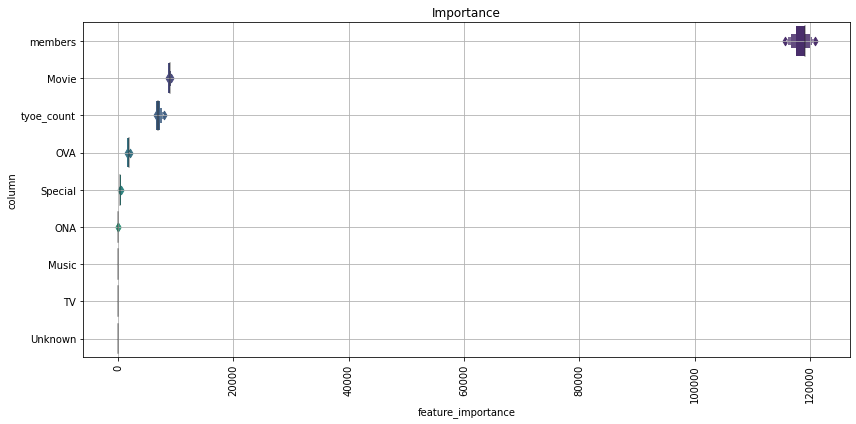

In [37]:
fig, ax = visualize_importance(models, train_feat_df)

* 特徴重要度でいうと `members` の重みが最も大きいようです。人気なアニメは評価が高くなったりする影響かも?
    * [@Masapichi さんの BIで手軽に！ Trainデータから人気作品を調べる](https://www.guruguru.science/competitions/21/discussions/55e578cd-65e2-4677-bd79-5b06d5726394/)なども参考になるかもしれません.
* アニメの種類でいうと Movie が最も影響度が大きいです。映画版は見に行く人が限られていて高評価をつけやすい?などの傾向があるのかもしれません。
* 他の特徴量を入れたときも特徴量重要度を見て、特徴量とユーザー評価の関係の気持ちを汲み取ってみてください。

## 推論する

最後に、学習したモデルを使って予測値への推論を作りましょう。今回 5Fold で学習しましたので5個分のモデルができていますので、その予測平均を使います。

In [38]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test_feat_df.values) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0) # axis=0 なので shape の `k` が潰れる 

## 予測結果の確認

テストデータへの予測結果の分布が、学習時に作った予測値 out of fold とずれていないか、を確認することを忘れないようにしてください。これが大きくずれている場合には、学習時の特徴量分布とテスト時の特徴量分布が異なっていることになりますので、その異なりは妥当かどうかを考える必要があります。

問題の構造上分布がずれることはしょうがない、という問題なら良いのですが、そうでないのにズレが発生する場合には、学習時の特徴量作成コードとテスト時の学習コードがずれいているなどのミスを疑う、などの対応が必要でしょう。(もっともこの場合 submit してスコアがでないのですぐわかりますが…)

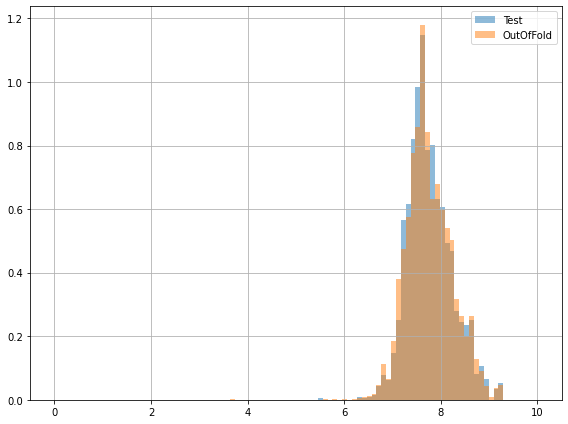

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = .02
bins = np.linspace(0, 10, 100)
ax.hist(pred, bins=bins, density=True, alpha=.5, label="Test")
ax.hist(oof, bins=bins, density=True, alpha=.5, label="OutOfFold")
ax.grid()
ax.legend()
# ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [40]:
pd.DataFrame({
    "score": pred
}).to_csv(os.path.join(OUTPUT_DIR, "#1__submission.csv"), index=False)